# Peer-graded Assignment: Эксперименты с моделью

На прошлой неделе вы поучаствовали в соревновании на kaggle и, наверняка, большинство успешно справилось с прохождением baseline, а значит пора двигаться дальше - заняться оптимизацией модели, провести серию экспериментов и построить сильное финальное решения.

В этом задании вам нужно провести ряд эскпериментов, оценить качество полученных в процессе экспериментирования моделей и выбрать лучшее решение. 

Задание будет оцениваться на основании загруженного jupyther notebook и развернутых ответов на поставленные вопросы.

# Данные

In [ ]:
# !unzip data.zip

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import os
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector as selector, ColumnTransformer

PATH_TO_DATA = 'data'

In [4]:
df = pd.read_csv(os.path.join(PATH_TO_DATA, 'orange_small_churn_data.train'))
y = pd.read_csv(os.path.join(PATH_TO_DATA, 'orange_small_churn_labels.train'), header=None, squeeze=True)

In [66]:
df_train, df_ho, y_train, y_valid = train_test_split(df, y, test_size=5000)

In [5]:
class NanColumnsDropper(BaseEstimator, TransformerMixin):
    def __init(self):
        super().__init__()

    def fit(self, X):
        self.nan_cols = X.loc[:, X.isna().all()].columns
        return self

    def transform(self, X):
        X_transformed = X.drop(self.nan_cols, axis=1)
        self.cols = X_transformed.columns
        return X_transformed

In [125]:
numeric_transformer = Pipeline([
    ('simple_imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('simple_imputer', SimpleImputer(strategy='most_frequent')),
    # ('ordinal_encoder', OrdinalEncoder())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, selector(dtype_exclude="object")),
    ('cat', categorical_transformer, selector(dtype_include="object"))
])

preprocessor_pipeline = Pipeline([
    ('nan_columns_dropper', NanColumnsDropper()),
    ('preprocessor', preprocessor),
    # ('scaler', StandardScaler())
])

In [127]:
%%time
X_train = preprocessor_pipeline.fit_transform(df_train)
X_train = pd.DataFrame(X_train, columns=preprocessor_pipeline['nan_columns_dropper'].cols)#.astype('int')
X_valid = preprocessor_pipeline.fit_transform(df_ho)
X_valid = pd.DataFrame(X_valid, columns=preprocessor_pipeline['nan_columns_dropper'].cols)#.astype('int')
X_train

CPU times: user 6.66 s, sys: 234 ms, total: 6.89 s
Wall time: 6.88 s


# Модель

In [ ]:
# !pip install catboost

In [16]:
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit
from sklearn.linear_model import RidgeClassifier, LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score

from catboost import CatBoostClassifier

In [14]:
cv = StratifiedShuffleSplit(n_splits=8, random_state=2179)

In [132]:
catboost_classifier = CatBoostClassifier(max_depth=6, n_estimators=100, cat_features=df_train.select_dtypes(include='object').columns.to_list())

In [131]:
%%time
scores = cross_val_score(estimator=catboost_classifier, X=X_train, y=y_train, cv=cv, n_jobs=-1, 
                         scoring='roc_auc')
print(scores, '\n', scores.mean())
# 500

[0.73701686 0.7426199  0.7481529  0.73398979 0.72326211 0.72637108
 0.75321581 0.70931861] 
 0.7342433820037987
CPU times: user 9.11 s, sys: 697 ms, total: 9.81 s
Wall time: 15min 12s


In [128]:
%%time
catboost_classifier.fit(X_train, y_train)
print(roc_auc_score(y_valid, catboost_classifier.predict_proba(X_valid)[:, 1]))

Learning rate set to 0.388375
0:	learn: 0.3803391	total: 102ms	remaining: 10.1s
1:	learn: 0.2948044	total: 212ms	remaining: 10.4s
2:	learn: 0.2689584	total: 324ms	remaining: 10.5s
3:	learn: 0.2588297	total: 420ms	remaining: 10.1s
4:	learn: 0.2507830	total: 521ms	remaining: 9.9s
5:	learn: 0.2452487	total: 611ms	remaining: 9.57s
6:	learn: 0.2433301	total: 705ms	remaining: 9.36s
7:	learn: 0.2415445	total: 796ms	remaining: 9.15s
8:	learn: 0.2397302	total: 885ms	remaining: 8.95s
9:	learn: 0.2382632	total: 982ms	remaining: 8.83s
10:	learn: 0.2380621	total: 1.01s	remaining: 8.22s
11:	learn: 0.2374295	total: 1.07s	remaining: 7.85s
12:	learn: 0.2366186	total: 1.16s	remaining: 7.76s
13:	learn: 0.2362548	total: 1.25s	remaining: 7.68s
14:	learn: 0.2355020	total: 1.35s	remaining: 7.64s
15:	learn: 0.2347734	total: 1.45s	remaining: 7.6s
16:	learn: 0.2341912	total: 1.53s	remaining: 7.49s
17:	learn: 0.2330727	total: 1.6s	remaining: 7.3s
18:	learn: 0.2329304	total: 1.69s	remaining: 7.2s
19:	learn: 0.232

In [120]:
%%time
gb_classifier = GradientBoostingClassifier(random_state=2179)
gb_classifier.fit(X_train, y_train)
print(roc_auc_score(y_valid, gb_classifier.predict_proba(X_valid)[:, 1]))

0.7208459259352309
CPU times: user 14.2 s, sys: 20.5 ms, total: 14.2 s
Wall time: 14.2 s


## Инструкции

1\. Начнем с простого. Давайте оценим как много объектов действительно нужно для построения качественной модели. Для обучения доступна достаточно большая выборка и может так оказаться, что начиная с некоторого момента рост размера обучающей выборки перестает влиять на качество модели. Постройте кривые обучения, обучая модель на выборках разного размера начиная с небольшого количество объектов в обучающей выборке и постепенно наращивая её размер с некоторым шагом. Обратите внимание на `sklearn.model_selection.learning_curve`

In [138]:
from sklearn.model_selection import  learning_curve

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [135]:
train_sizes_abs, train_scores, test_scores, fit_times, score_times = learning_curve(
    estimator=catboost_classifier,
    X=X_train,
    y=y_train,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    return_times=True
)

In [143]:
test_scores

array([[0.67532407, 0.68642094, 0.69925807, 0.66919634, 0.65905152,
        0.68482312, 0.70379274, 0.66821581],
       [0.69969017, 0.69805199, 0.71174027, 0.71211182, 0.71043566,
        0.71249763, 0.71643993, 0.68363841],
       [0.71784544, 0.71242759, 0.72310304, 0.71171652, 0.70617047,
        0.71900404, 0.72040361, 0.68873219],
       [0.71748813, 0.70405983, 0.73029084, 0.71878324, 0.71620014,
        0.7107538 , 0.71807692, 0.69248101],
       [0.71953348, 0.71474834, 0.72884615, 0.7359283 , 0.71819919,
        0.73370133, 0.73860636, 0.6865717 ]])

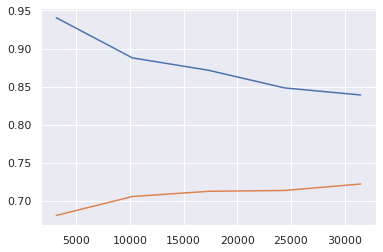

In [148]:
sns.lineplot(x=train_sizes_abs, y=train_scores.mean(axis=1))
sns.lineplot(x=train_sizes_abs, y=test_scores.mean(axis=1));

2\. Часто несбалансированные по классам выборки приводят к различным проблемам при обучении моделей. Давайте попробуем по-разному обработать выборку, поиграть с распределением объектов по классам и сделать выводы о том, как соотношение классов влияет на качество модели.

2.1\. Задайте веса объектам так, чтобы соотношение классов с учетом весов объектов изменилось. Попробуйте не менее трёх различных вариантов весов. Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

2.2\. Примените к выборке технологию undersampling: для этого нужно убрать из обучения некоторое количество объектов большего класса таким образом, чтобы соотношение классов изменилось. Попробуйте не менее трёх различных вариантов undersampling (варианты могут отличаться как по количество отфильтрованных объектов, так и по принципу выборка объектов для отсеивания из выборки). Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

3\. Теперь перейдем к работе с признаками. Ранее вы реализовали несколько стратегий для обработки пропущенных значений. Сравните эти стратегии между собой с помощью оценки качества моделей кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка пропущенных значений сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

4\. Также вы уже реализовали несколько стратегий для обработки категориальных признаков. Сравните эти стратегии между собой с помощью оценки качества моделей по кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка категориальных признаков сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

5\. Все ли признаки оказались полезными для построения моделей? Проведите процедуру отбора признаков, попробуйте разные варианты отбора (обратите внимание на модуль `sklearn.feature_selection`). Например, можно выбрасывать случайные признаки или строить отбор на основе l1-регуляризации - отфильтровать из обучения признаки, которые получат нулевой вес при построении регрессии с l1-регуляризацией (`sklearn.linear_model.Lasso`). И всегда можно придумать что-то своё=) Попробуйте как минимум 2 различные стратегии, сравните результаты. Помог ли отбор признаков улучшить качество модели? Поясните свой ответ.

6\. Подберите оптимальные параметры модели. Обратите внимание, что в зависимости от того, как вы обработали исходные данные, сделали ли балансировку классов, сколько объектов оставили в обучающей выборке и др. оптимальные значения параметров могут меняться. Возьмите наилучшее из ваших решений на текущий момент и проведите процедуру подбора параметров модели (обратите внимание на `sklearn.model_selection.GridSearchCV`) Как подбор параметров повлиял на качество модели?

7\. Предложите методику оценки того, какие признаки внесли наибольший вклад в модель (например, это могут быть веса в случае регрессии, а также большое количество моделей реализуют метод `feature_importances_` - оценка важности признаков). На основе предложенной методики проанализируйте, какие признаки внесли больший вклад в модель, а какие меньший?

8\. Напоследок давайте посмотрим на объекты. На каких объектах достигается наибольшая ошибка классификации? Есть ли межу этими объектами что-то общее? Видны ли какие-либо закономерности? Предположите, почему наибольшая ошибка достигается именно на этих объектах. В данном случае "наибольшую" ошибку можно понимать как отнесение объекта с чужому классу с большой долей уверенности (с высокой вероятностью).

9\. По итогам проведенных экспериментов постройте финальную решение - модель с наилучшим качеством. Укажите, какие преобразования данных, параметры и пр. вы выбрали для построения финальной модели.

10\. Подумайте, можно ли еще улучшить модель? Что для этого можно сделать? 

# Тест

In [96]:
def write_to_submission_file(predicted_labels, out_file,
                             target='result', index_label="id"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(0, predicted_labels.shape[0]),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [97]:
df_test = pd.read_csv(os.path.join(PATH_TO_DATA, 'orange_small_churn_test_data.csv'), index_col=0)
df_test

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,Var11,Var12,Var13,Var14,Var15,Var16,Var17,Var18,Var19,Var20,Var21,Var22,Var23,Var24,Var25,Var26,Var27,Var28,Var29,Var30,Var31,Var32,Var33,Var34,Var35,Var36,Var37,Var38,Var39,Var40,...,Var191,Var192,Var193,Var194,Var195,Var196,Var197,Var198,Var199,Var200,Var201,Var202,Var203,Var204,Var205,Var206,Var207,Var208,Var209,Var210,Var211,Var212,Var213,Var214,Var215,Var216,Var217,Var218,Var219,Var220,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,1225.0,7.0,NaN,NaN,NaN,NaN,NaN,2352.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180.0,225.0,NaN,0.0,56.0,NaN,NaN,388.08,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,6726960.0,NaN,NaN,...,NaN,P1WvyxLp3Z,2Knk1KF,NaN,taul,1K8T,0Xwj,PHNvXy8,xUOdRmdN20,IBm9AvG,NaN,skcI,HLqf,vzJD,NaN,lVqb,NKv3VA1BpP,sBgB,NaN,uKAI,L84s,Ie_5MZs,NaN,xRz9wph,NaN,CWNY2py,jgOV,UYBR,FzaX,UF16siJ,zCkv,APgdzOv,jySVZNlOJy,NaN,ELof,xb3V,6fzt,Zy3gnGM,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,896.0,14.0,NaN,NaN,NaN,NaN,NaN,1560.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,112.0,140.0,NaN,0.0,96.0,NaN,NaN,133.12,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,...,NaN,bZkvyxLkBI,RO12,NaN,taul,1K8T,0Xwj,6KF0k8W,V4E_TU9097,NaN,NaN,CZsd,F3hy,vzJD,09_Q,IYzP,me75fM6ugJ,kIsH,NaN,uKAI,L84s,NhsEn4L,NaN,NaN,NaN,TDcECyH,PDRj,cJvF,FzaX,ot6oLzk,oslk,IIvC99a,LM8l689qOp,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,791.0,7.0,NaN,NaN,NaN,NaN,NaN,2824.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,172.0,215.0,NaN,4.0,16.0,NaN,NaN,324.48,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,2988486.0,NaN,NaN,...,NaN,75lTmBtFkL,RO12,SEuy,taul,1K8T,AnrR,ckoNVBU,_jTP8ioIlJ,JnrRQD4,smXZ,PwdO,9_Y1,C6Eu,VpdQ,sYC_,me75fM6ugJ,kIsH,NaN,uKAI,Mtgm,NhsEn4L,NaN,Iy8LM_S,NaN,kq0aHkC,laMb,UYBR,FzaX,6VLNqhB,oslk,6YSocsg,LM8l689qOp,NaN,kG3k,rgKb,RAYp,F2FyR07IdsN7I,mj86,NaN
3,NaN,NaN,NaN,NaN,NaN,2296.0,7.0,NaN,NaN,NaN,NaN,NaN,3732.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,480.0,600.0,NaN,10.0,104.0,NaN,NaN,286.96,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,6637740.0,NaN,NaN,...,NaN,YddTmBtueT,RO12,SEuy,taul,1K8T,487l,77f44U8,II0S8f9,a1lFLoc,smXZ,SOkz,9_Y1,C6Eu,VpdQ,IYzP,me75fM6ugJ,kIsH,NaN,uKAI,L84s,NhsEn4L,NaN,GccbB3h,NaN,mAjbk_S,qLRt,UYBR,FzaX,tzp8jNM,oslk,5nQ7A2G,jySVZNlOJy,NaN,kG3k,rgKb,RAYp,F2FyR07IdsN7I,am7c,NaN
4,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,mCGq9ayE15,RO12,NaN,taul,1K8T,lK27,esxkA1P,767sa0XN9l,NaN,NaN,kVZt,9_Y1,vm5R,09_Q,NaN,me75fM6ugJ,kIsH,NaN,uKAI,Mtgm,NhsEn4L,NaN,NaN,eGzu,7Wwvby0,XqfQ,UYBR,FzaX,EPImS85,oslk,MI8s5nE,LM8l689qOp,NaN,NaN,7P5s,RAYp,F2FyR07IdsN7I,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,NaN,NaN,NaN,NaN,NaN,714.0,7.0,NaN,NaN,NaN,NaN,NaN,2240.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120.0,150.0,NaN,10.0,80.0,NaN,NaN,133.12,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,...,NaN,m9SvyxLkBI,RO12,NaN,taul,1K8T,GYbZ,iJzviRg,3X0xOLn,jCrHwxI,NaN,CGbI,9_Y1,lXxA,09_Q,wMei,7M47J5GA0pTYIFxg5uy,kIsH,NaN,uKAI,L84s,4kVnq_T26xq1p,NaN,xXRNJU2,NaN,uZLuDix,vawI,cJvF,Lmli,ch2oGfM,zCkv,P6pu4Vl,LM8l689qOp,NaN,ELof,xb3V,ZI9m,R4y5gQQWY8OodqDV,am7c,NaN
9996,NaN,NaN,NaN,NaN,NaN,812.0,7.0,NaN,NaN,NaN,NaN,NaN,2020.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,136.0,170.0,NaN,0.0,104.0,NaN,NaN,253.52,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,4147200.0,NaN,NaN,...,NaN,HYTrjIK12c,2Knk1KF,NaN,taul,1K8T,JLbT,BMnJ89M,5CtupK8,8DWmKv5,NaN,mK1t,9_Y1,7WNq,VpdQ,hAFG,me75fM6ugJ,kIsH,NaN,uKAI,L84s,XfqtO3UdzaXh_,NaN,Oc9VkgP,NaN,XTbPUYD,jQNd,cJvF,FzaX,8d5YWu3,oslk,sXbT3Cb,LM8l689qOp,NaN,ELof,WqMG,RAYp,55YFVY9,mj86,NaN
9997,NaN,NaN,NaN,NaN,NaN,819.0,7.0,NaN,NaN,NaN,NaN,NaN,40.0,NaN,NaN,NaN,NaN,NaN,

In [100]:
%%time
X_test = preprocessor_pipeline.fit_transform(df_test)
X_test = pd.DataFrame(X_test, columns=preprocessor_pipeline['nan_columns_dropper'].cols)#.astype('int')
X_test

CPU times: user 708 ms, sys: 20.7 ms, total: 729 ms
Wall time: 734 ms


In [101]:
%%time
catboost_classifier.fit(X_train, y_train)
prediction = catboost_classifier.predict_proba(X_test)

In [102]:
write_to_submission_file(prediction[:, 1], 'result.csv')